In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime, time

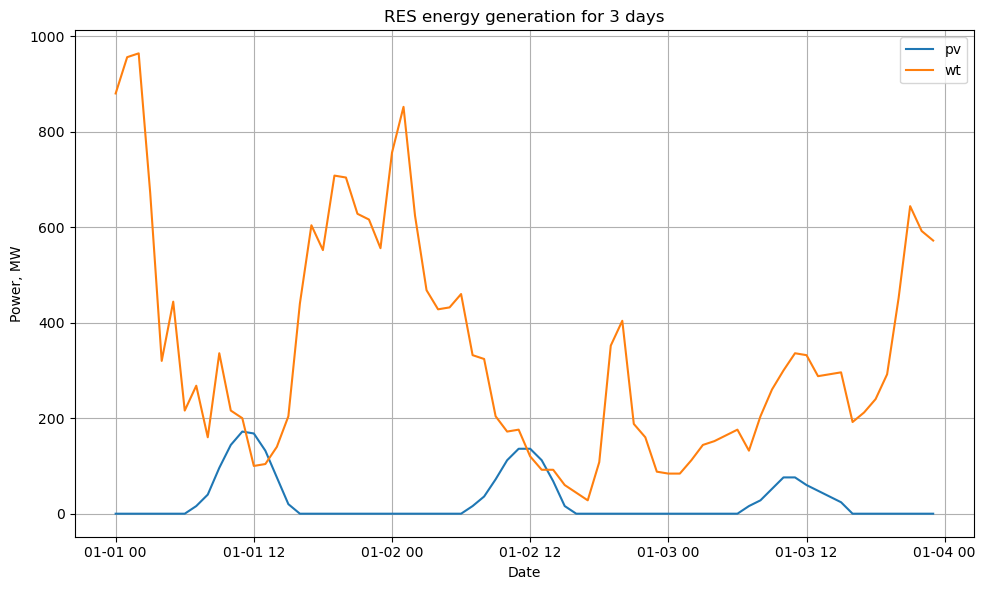

In [116]:
DAYS = 3

# Load CSV data
pv_energy = '2023_photovoltaic_total_at.csv'  # Replace with your actual file path
wt_energy = '2023_windpower_total_at.csv'  # Replace with your actual file path

pv = pd.read_csv(pv_energy, delimiter=';')
wt = pd.read_csv(wt_energy, delimiter=';')

# Convert 'Date' to datetime if applicable
pv['Date'] = pd.to_datetime(pv['Date'], utc=True)
wt['Date'] = pd.to_datetime(wt['Date'], utc=True)

pv_arr = pv['Power (MW)'].to_numpy()
wt_arr = wt['Power (MW)'].to_numpy()
# Plotting

plt.figure(figsize=(10, 6))
plt.plot(pv['Date'][0:24*DAYS], pv['Power (MW)'][0:24*DAYS], label='pv')
#plt.plot(pv_arr[0:24*DAYS])
plt.plot(wt['Date'][0:24*DAYS], wt['Power (MW)'][0:24*DAYS], label='wt')
plt.title(f'RES energy generation for {DAYS} days')
plt.xlabel('Date')
plt.ylabel('Power, MW')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

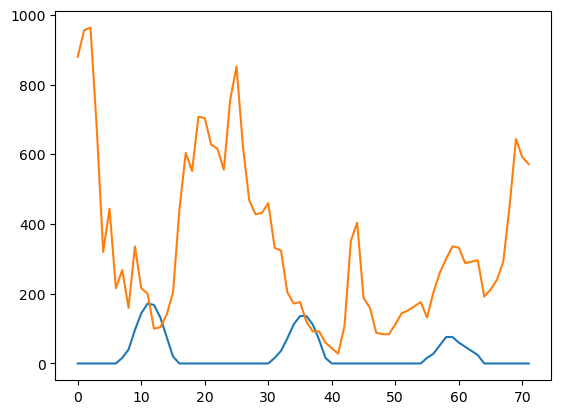

In [118]:
plt.plot(pv_arr[0:24*DAYS])
plt.plot(wt_arr[0:24*DAYS])

In [87]:
# Helper function
def extract_hour(value):
    try:
        if isinstance(value, str):
            value = pd.to_datetime(value)
        if isinstance(value, (datetime, pd.Timestamp)):
            return value.hour + value.minute / 60
        elif isinstance(value, time):
            return value.hour + value.minute / 60
        elif isinstance(value, (int, float)):
            return float(value)
    except Exception:
        pass
    raise ValueError(f"Unsupported time format: {value}")

# EV class
class ElectricVehicle:
    def __init__(self, profile_row, battery_capacity=10000):
        self.arrival = extract_hour(profile_row['arrivalAtHome'])
        self.departure = extract_hour(profile_row['departureFromHome'])
        self.consumption = float(profile_row['consumption'])
        self.capacity = battery_capacity
        self.initial_soc = random.uniform(0.1, 0.2) * self.capacity
        self.soc = self.initial_soc

    def reset_day(self):
        """Reset SoC randomly for new day."""
        self.initial_soc = random.uniform(0.1, 0.2) * self.capacity
        self.soc = self.initial_soc

    def simulate_day(self, time_step=0.25):
        """Simulate one day with arrival, departure, and charging."""
        self.soc -= self.consumption
        self.soc = max(self.soc, 0)

        charging_duration = (self.departure - self.arrival) % 24
        steps = int(charging_duration / time_step)

        goal_soc = self.consumption
        power_per_step = (goal_soc - self.soc) / charging_duration if charging_duration > 0 else 0

        for _ in range(steps):
            if self.soc >= self.capacity:
                break
            self.soc += min(power_per_step * time_step, self.capacity - self.soc)

        return {
            'Initial SoC': round(self.initial_soc, 2),
            'Goal (kWh)': round(self.consumption, 2),
            'Arrival (h)': round(self.arrival, 2),
            'Departure (h)': round(self.departure, 2)
        }

# Fleet manager
class EVFleet:
    def __init__(self, xlsx_path, num_vehicles=10):
        df = pd.read_excel(xlsx_path)
        self.profiles = df
        self.vehicles = [ElectricVehicle(df.sample(n=1).iloc[0]) for _ in range(num_vehicles)]

    def simulate_multiple_days(self, num_days=1):
        all_results = []
        for day in range(num_days):
            for i, ev in enumerate(self.vehicles):
                ev.reset_day()
                daily_result = ev.simulate_day()
                daily_result.update({'EV': i, 'Day': day + 1})
                all_results.append(daily_result)
        return all_results

In [91]:
fleet = EVFleet(xlsx_path='EV_UsageProfile.xlsx', num_vehicles=5)
results = fleet.simulate_multiple_days(num_days=3)

for row in results:
    print(row)

{'Initial SoC': 1914.81, 'Goal (kWh)': 8000.0, 'Arrival (h)': 16.25, 'Departure (h)': 6.5, 'EV': 0, 'Day': 1}
{'Initial SoC': 1567.64, 'Goal (kWh)': 8000.0, 'Arrival (h)': 16.25, 'Departure (h)': 6.5, 'EV': 1, 'Day': 1}
{'Initial SoC': 1764.31, 'Goal (kWh)': 8000.0, 'Arrival (h)': 13.0, 'Departure (h)': 6.5, 'EV': 2, 'Day': 1}
{'Initial SoC': 1855.99, 'Goal (kWh)': 8000.0, 'Arrival (h)': 13.0, 'Departure (h)': 6.5, 'EV': 3, 'Day': 1}
{'Initial SoC': 1536.31, 'Goal (kWh)': 8000.0, 'Arrival (h)': 16.25, 'Departure (h)': 6.5, 'EV': 4, 'Day': 1}
{'Initial SoC': 1407.77, 'Goal (kWh)': 8000.0, 'Arrival (h)': 16.25, 'Departure (h)': 6.5, 'EV': 0, 'Day': 2}
{'Initial SoC': 1587.5, 'Goal (kWh)': 8000.0, 'Arrival (h)': 16.25, 'Departure (h)': 6.5, 'EV': 1, 'Day': 2}
{'Initial SoC': 1783.97, 'Goal (kWh)': 8000.0, 'Arrival (h)': 13.0, 'Departure (h)': 6.5, 'EV': 2, 'Day': 2}
{'Initial SoC': 1610.59, 'Goal (kWh)': 8000.0, 'Arrival (h)': 13.0, 'Departure (h)': 6.5, 'EV': 3, 'Day': 2}
{'Initial SoC':